In [14]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
%matplotlib inline
import math


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
import glob
np.random.seed(42)


import warnings
warnings.filterwarnings('ignore')

In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100): 
        display(df)

## Model Selection

## <p style="text-align: center;">What Model to Use?</p>

![alt text](models.png "Title")

### Some thoughts
- Given the nature of our data (continuous dependent variable), we need to use a regressor to predict quality values.
- We considered a number of different regressors, including: Support Vector Machines (SVR), 
    + Linear regression with Ordinary Least Squares (OLS) methodology 
    + XGBoost
    + RandomForestRegressor 
    + KNeighborsRegressor
    + MLPRegressor
    + GradientBoostingRegressor
    

In [17]:
#get model attributes
# def select_model(X, Y):

#     best_models = {}
#     models = [
#         {   'name': 'LinearRegression',
#             'estimator': LinearRegression() 
#         },
#         {   'name': 'KNeighborsRegressor',
#             'estimator': KNeighborsRegressor(),
#         },
#         {   'name': 'RandomForestRegressor',
#             'estimator': RandomForestRegressor(),
#         },
#         {   'name': 'MLPRegressor',
#             'estimator': MLPRegressor(),
#         },
#         {   'name': 'GradientBoostingRegressor',
#             'estimator': GradientBoostingRegressor(),
#         },
#         {   'name': 'XGBoost',
#             'estimator': XGBRegressor(),
#         },        
#     ]
    
#     for model in tqdm(models):
#         start = time.perf_counter()
#         print(model)
#         grid = GridSearchCV(model['estimator'], param_grid={}, cv=5, scoring = "neg_mean_squared_error", verbose=False, n_jobs=-1)
#         grid.fit(X, Y)
#         best_models[model['name']] = {'score': grid.best_score_, 'params': grid.best_params_, 'model':model['estimator']}
#         run = time.perf_counter() - start
        
#     return best_models

In [18]:
# models = select_model(X_train, y_train)

In [19]:
#find best model
# best_model = None
# max_score = -100
# best_model_name = ''

# for m in models:
#     print(m, models[m]['score'])
#     if models[m]['score'] > max_score:
#         max_score = models[m]['score']
#         best_model = models[m]['model']
#         best_model_name = m
        
# print(best_model_name, max_score)

### Models we used for our project:
- XGBoost 
- RandomForestRegressor  
  
    
    
    

## <p style="text-align: center;">What Is XGBoost?</p>

![alt text](xgb.png "Title")

## <p style="text-align: center;">XGBoost Evloution</p>

![alt text](xgb_evolution.jpeg "Title")

## <p style="text-align: center;">RandomForestRegressor Overview</p>

![alt text](rf_reg.png "Title")

In [20]:
#Do NOT run
def filtering_features_pipeline(data, target_file, temp_increase_vars):
    '''
    Function to run all of our preprocessing functionalities, with a few different configuration options.
    Will save a new dataframe as csv file in a specified address
    
    INPUTS:
    data: a pandas dataframe containing the raw data
    target_file: a file name and address to save the preprocessed data frames. expects .csv extension
    temp_increase_vars: a boolean value (True or False) on whether or not to create the binary temperature increase variables
    
    OUTPUTS:
    data: a data frame with the preprocessed data
    file saved... the preprocessed data frame saved as a csv file at the specified file extension
    '''
    
    #Add campaign duration and campaignID columns
    #Need to convert column to date_time type
    data['Date.Time'] = pd.to_datetime(data['Date.Time'])

    #Loop through and identify consecutive dates. Create a list of campaign IDs to then create a column from.
    campaign_num = 1
    campaign_id_list = [1]
    for index in range(1,len(data['Date.Time'])):
        if (data['Date.Time'][index] - data['Date.Time'][index-1]).days < 1:
            campaign_id_list.append(campaign_num)
        else:
            campaign_num += 1
            campaign_id_list.append(campaign_num)

    #Create new column of campaign IDs:
    data['CampaignID'] = campaign_id_list

    #Loop through and calculate hours in campaign
    duration_list = [0]

    for index in range(1,len(data['Date.Time'])):
        campaign_num = data['CampaignID'][index]
        campaign_start = min(data['Date.Time'][data['CampaignID'] == campaign_num])
        hrs_since_start = (data['Date.Time'][index] - campaign_start).delta*2.77778e-13
        duration_list.append(hrs_since_start)

    #Create new column for campaign hours
    data['Campaign.Hrs'] = duration_list
    
    dates = data['Date.Time']
    data.drop(['Unnamed: 0', 'Date.Time'], axis = 1, inplace = True)
    
    data.drop(['Pressure'], axis = 1, inplace = True)
    
    #delete rows where Main_Mass_Flow =0
    rows_to_delete = np.where(data.Main_Mass_Flow == 0)[0]
    # also add 337, 2533
    rows_to_delete = np.sort(np.concatenate((rows_to_delete, np.array([337, 2533])), axis = 0))

    data.drop(rows_to_delete, axis = 0, inplace = True)
    
    # replace T_Zone_1 zero vals with median
    new_zero_val_T = np.median(data.T_Zone_1.iloc[np.where(data.T_Zone_1 > 50)])
    data.T_Zone_1.iloc[np.where(data.T_Zone_1 <= 50)] = new_zero_val_T

    # replace Blending vals with median
    new_zero_val_B = np.median(data.Blending.iloc[np.where(data.Blending > 20)])
    data.Blending.iloc[np.where(data.Blending <= 20)] = new_zero_val_B
    
    data = data[data.Main_Mass_Flow > 15000]
    
    if temp_increase_vars:
        for i in range(1,10):
            new_colname = "T_Increase_" + str(i)
            colname_i = "T_Zone_" + str(i)
            colname_inext = "T_Zone_" + str(i+1)
            vals = (data[colname_i] <= data[colname_inext]).astype(int)
            data[new_colname] = vals
   
    data.to_csv(target_file)
    return data


In [23]:
#Do NOT run

def scale_training(data, scaler):
    '''
    A function that will peform scaling on training data given that all features are already created.
    
    INPUTS:
    data: a pandas dataframe to be scaled
    scaler: a scaling protocol: "standard" or "minmax"
    
    RETURNS:
    scaler: a scaler object that can be used to scale testing data
    scaled_features: a scaled pandas dataframe object
    '''
    if scaler == "standard":
        scaled_colnames = data.columns
        scaled_features = data.copy()
        features = scaled_features[scaled_colnames]
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)
        scaled_features[scaled_colnames] = features
        
    elif scaler == "minmax":
        scaled_colnames = data.columns
        scaled_features = data.copy()
        features = scaled_features[scaled_colnames]
        scaler = MinMaxScaler().fit(features.values)
        features = scaler.transform(features.values)
        scaled_features[scaled_colnames] = features
    
    else:
        raise ValueError(scaler)
        
    return scaler, scaled_features


In [13]:
# data = pd.read_csv("anonymized_SAP_data.csv")

In [27]:
# filtering_features_pipeline(data, 'no_tempinc.csv', False)

In [16]:
# filtering_features_pipeline(data, 'tempinc.csv', True)

In [18]:
# data_files = ['no_tempinc.csv', 'tempinc.csv']

In [20]:
# scalers = ['standard','minmax']

In [35]:
# for file in data_files:
#     data = pd.read_csv(str('./p_data/')+file)
#     for scaler in scalers:
#         sc, temp_df = scale_training(data,scaler)
#         file_name = file[:-4]+ str('_') + scaler + str('.csv')
#         temp_df.to_csv('./p_data/'+file_name)
        

In [26]:
# data = pd.read_csv("anonymized_SAP_data.csv")

# filtering_features_pipeline(data, 'no_tempinc.csv', False)

# filtering_features_pipeline(data, 'tempinc.csv', True)

# data_files = ['no_tempinc.csv', 'tempinc.csv']

# scalers = ['standard','minmax']

# for file in data_files:
#     data = pd.read_csv(str('./p_data/')+file)
#     for scaler in scalers:
#         sc, temp_df = scale_training(data,scaler)
#         file_name = file[:-4]+ str('_') + scaler + str('.csv')
#         temp_df.to_csv('./p_data/'+file_name)


In [27]:
def oversample_extremes(data, low_val=42, low_weight=2, high_val=48, high_weight=2):
    '''
    A function that will create duplicate rows of specified rows in order to weight certain rows in machine learning training
    
    INPUTS:
    data: a pandas dataframe
    low_val: value of 'Quality' below which we will duplicate rows
    low_weight: integer of effective weight desired for low values
    high_val: value of 'Quality' above which we will duplicate rows
    high_weight: integer for effective weight desired for high values
    
    RETURNS:
    newdata: a pandas dataframe with duplicated rows according to the arguments passed
    
    NOTES:
    
    'low_weight' and 'high_weight' both need integer values and correspond to the effective weight of the sample compared
    to the rest of the data in the dataframe. For an example, a weight of 2 would mean creating 1 duplicate (so the
    row is now in the data twice), and a weight of 1 would return the same dataset (no additional duplicates created)
    
    Default cutoff values correspond to roughly anything outside the IQR
    '''
    # identify rows of interest
    low_df = data.loc[data['Quality'] < low_val]
    high_df = data.loc[data['Quality'] > high_val]
    
    newdata = data.copy()
    
    # loop to add on all the rows
    
    for i in range(low_weight-1): #pythonic indexing...
        newdata = newdata.append(low_df, ignore_index = True)
    for i in range(high_weight-1):
        newdata = newdata.append(high_df, ignore_index = True)
    
    return(newdata)
    

### XGBRegressor

**Without sampling**


Dataset: no_tempinc.csv


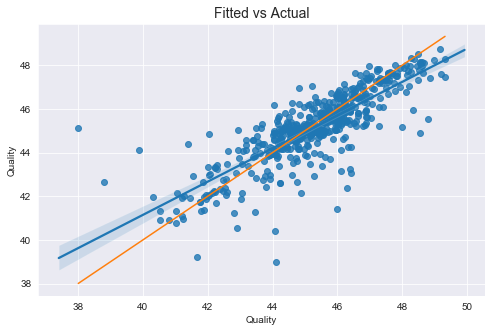


Dataset: no_tempinc_minmax.csv


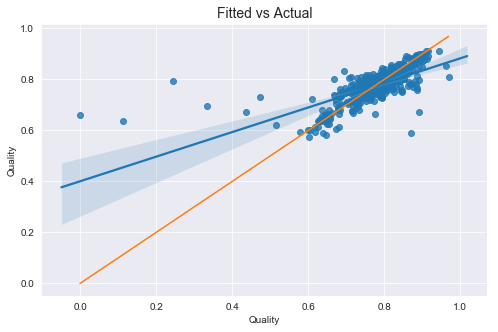


Dataset: no_tempinc_standard.csv


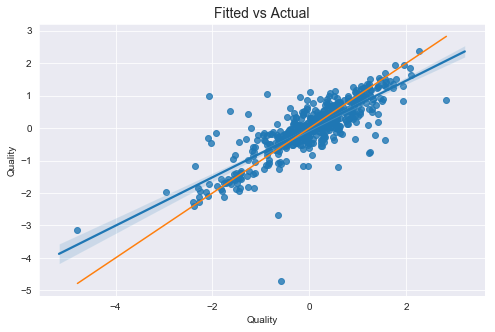


Dataset: tempinc.csv


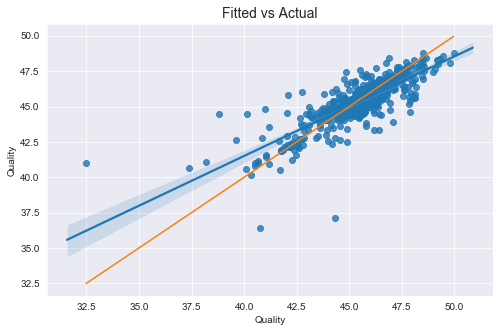


Dataset: tempinc_minmax.csv


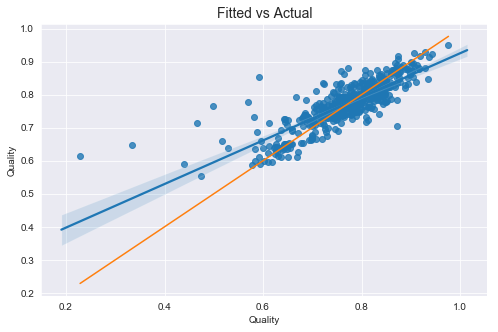


Dataset: tempinc_standard.csv


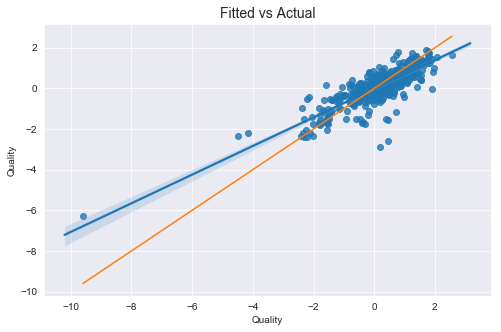

In [31]:
xgb_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test

    xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15, random_state=3)
    

    xgb_fit = xgb_ml.fit(X_train, y_train)
    xgb_preds = xgb_fit.predict(X_val)
#     print(xgb_ml.feature_importances_)
    
    mae = mean_absolute_error(y_val, xgb_preds)
    mse = mean_squared_error(y_val, xgb_preds)
    r_squared = r2_score(y_val, xgb_preds)
    
    xgb_dict[str(file)] = {}
    xgb_dict[str(file)]['mae'] = mae
    xgb_dict[str(file)]['mse'] = mse
    xgb_dict[str(file)]['r_squared'] = r_squared
    xgb_dict[str(file)]['feat_imp'] = xgb_ml.feature_importances_
    
    plt.figure(figsize=(8,5))
    print('\nDataset:', str(file))
    sns.set_style("darkgrid")
    ax = sns.regplot(x=y_val, y=xgb_preds)
#     ax = sns.lineplot(x=y_val, y=xgb_preds)
    ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
    plt.title("Fitted vs Actual",  fontsize='14')
    plt.show()
    

In [32]:
xgb_df = pd.DataFrame.from_dict(xgb_dict)

In [33]:
xgb_df.T

,feat_imp,mae,mse,r_squared
no_tempinc.csv,"[0.018961001, 0.012710622, 0.72244096, 0.01029...",0.667499,1.02595,0.661455
no_tempinc_minmax.csv,"[0.0032606525, 0.0, 0.004483474, 0.9209425, 0....",0.0299552,0.00379433,0.490006
no_tempinc_standard.csv,"[0.0028349657, 0.0, 0.004408698, 0.9122267, 0....",0.341918,0.282501,0.656675
tempinc.csv,"[0.00899829, 0.008351728, 0.77662575, 0.007496...",0.699491,1.20329,0.67468
tempinc_minmax.csv,"[0.002338941, 0.0, 0.0023245416, 0.90684587, 0...",0.029826,0.00229038,0.68316
tempinc_standard.csv,"[0.0037931504, 0.0, 0.004644645, 0.9039884, 0....",0.359193,0.294903,0.701696


**With sampling**


Dataset: no_tempinc.csv Weight: 1


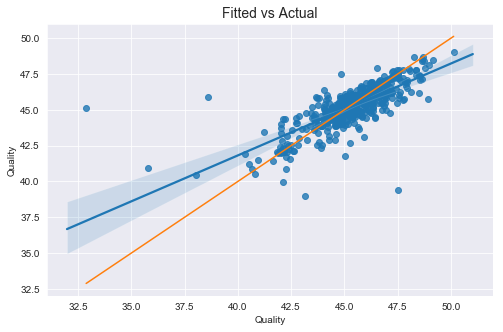


Dataset: no_tempinc.csv Weight: 3


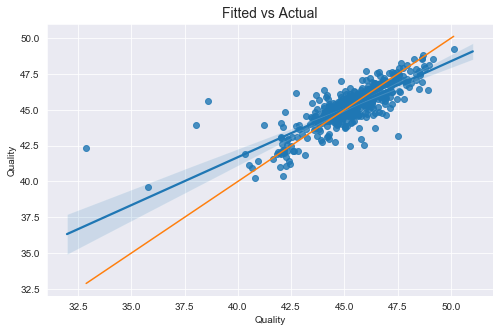


Dataset: no_tempinc.csv Weight: 5


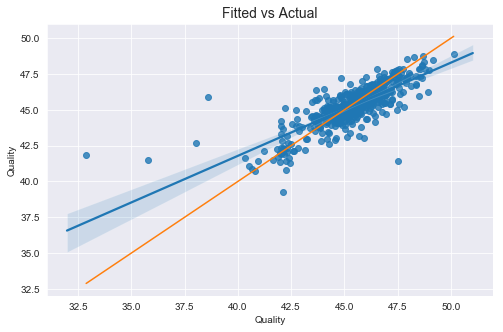


Dataset: no_tempinc_minmax.csv Weight: 1


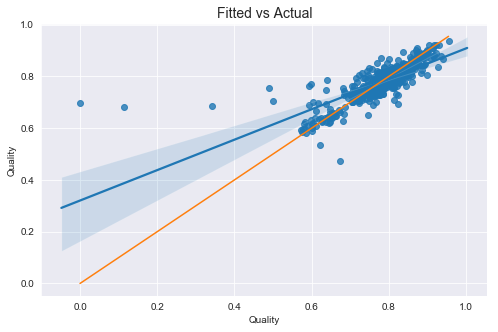


Dataset: no_tempinc_minmax.csv Weight: 3


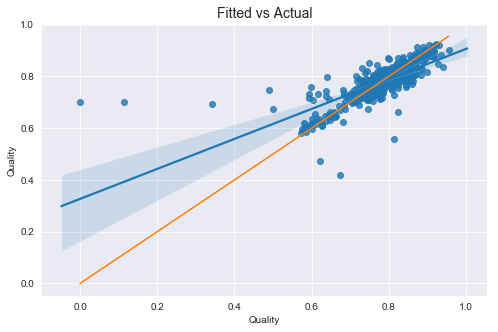


Dataset: no_tempinc_minmax.csv Weight: 5


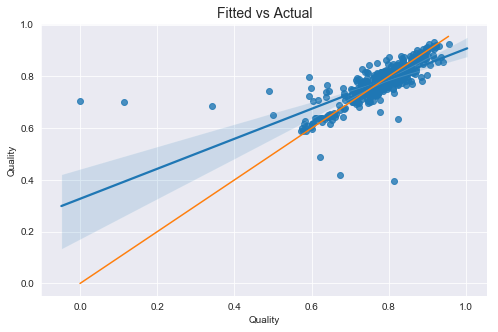


Dataset: no_tempinc_standard.csv Weight: 1


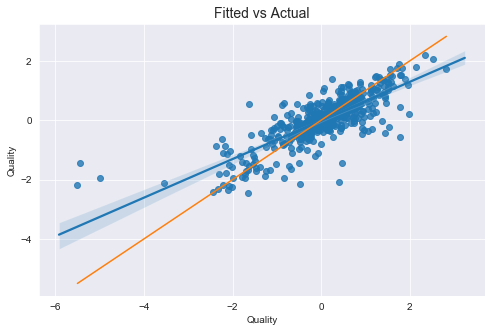


Dataset: no_tempinc_standard.csv Weight: 3


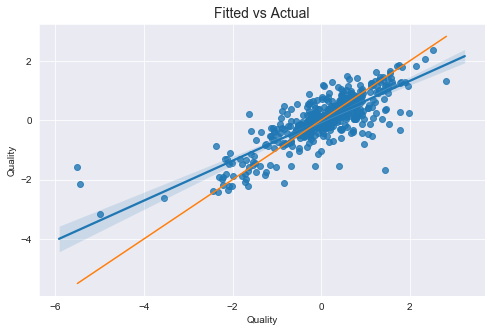


Dataset: no_tempinc_standard.csv Weight: 5


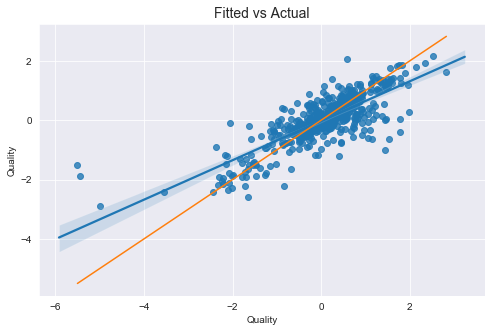


Dataset: tempinc.csv Weight: 1


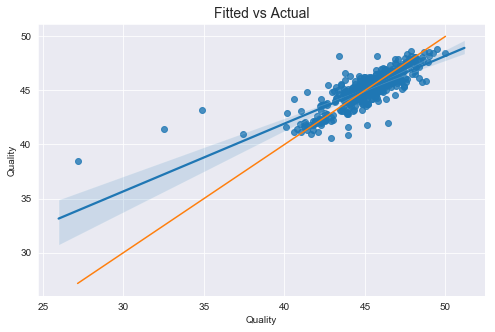


Dataset: tempinc.csv Weight: 3


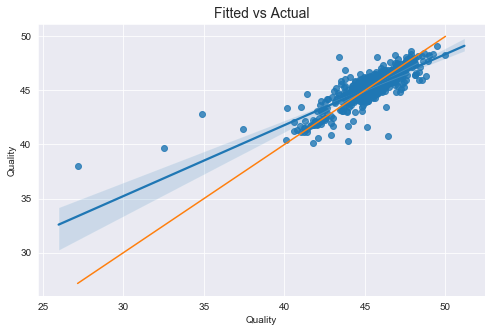


Dataset: tempinc.csv Weight: 5


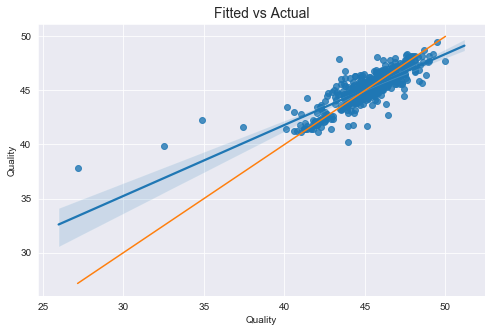


Dataset: tempinc_minmax.csv Weight: 1


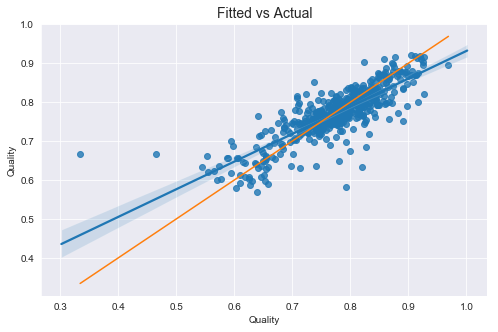


Dataset: tempinc_minmax.csv Weight: 3


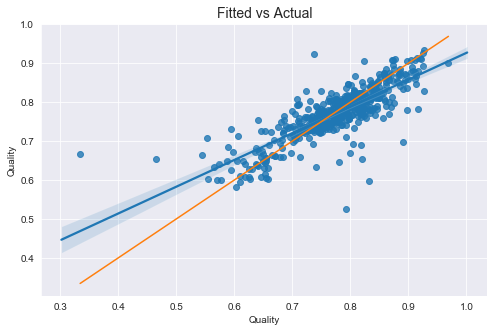


Dataset: tempinc_minmax.csv Weight: 5


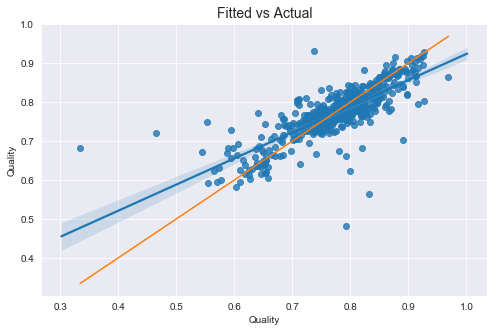


Dataset: tempinc_standard.csv Weight: 1


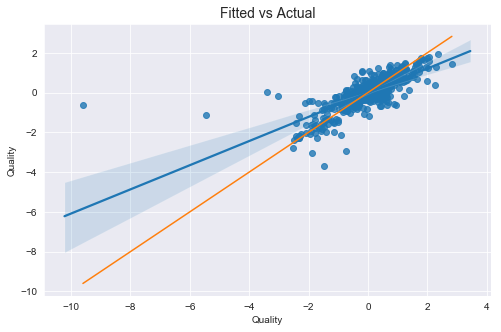


Dataset: tempinc_standard.csv Weight: 3


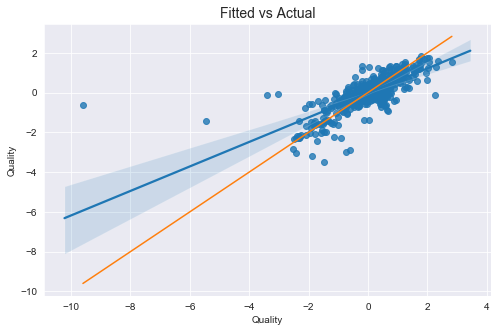


Dataset: tempinc_standard.csv Weight: 5


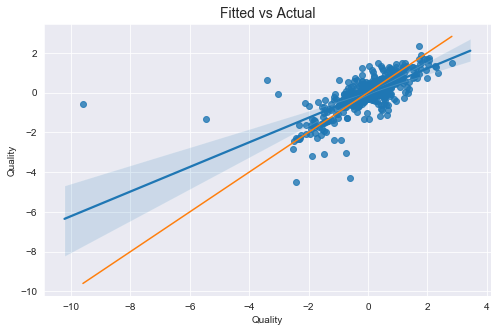

In [34]:
xgb_s_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):

    df = pd.read_csv(file)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        xgb_ml = xgb.XGBRegressor(n_estimators=160, max_depth=15, random_state=3)
        
        xgb_fit = xgb_ml.fit(X_train, y_train)
        xgb_preds = xgb_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, xgb_preds)
        mse = mean_squared_error(y_val, xgb_preds)
        r_squared = r2_score(y_val, xgb_preds)
        
        xgb_s_dict[str(file) + '_w' + str(w)] = {}
        xgb_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        xgb_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        xgb_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        xgb_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = xgb_ml.feature_importances_
        
        plt.figure(figsize=(8, 5))
        print('\nDataset:', str(file), "Weight:", w)
        sns.set_style("darkgrid")
        ax = sns.regplot(x=y_val, y=xgb_preds)
        ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
        plt.title("Fitted vs Actual",  fontsize='14')
        plt.show()

In [35]:
xgb_s_df = pd.DataFrame.from_dict(xgb_s_dict)

In [36]:
xgb_summ = pd.concat([xgb_df.T, xgb_s_df.T])

In [37]:
xgb_summ['Model'] = 'XGB'

### RandomForestRegressor

In [38]:
#get best hyper parameters for the model
# hyperparameters = {
#     'n_estimators': range(90, 201, 10),
#     'max_depth': range(2, 12, 2),
#     'min_samples_split' : range(2, 10, 2),
#     'min_samples_leaf' : list(range(1, 10, 1))
# #     'min_weight_fraction_leaf' : (0.0)
#                               }

# grid = GridSearchCV(base_model, param_grid=hyperparameters, n_jobs=-1)
# grid.fit(X_train, y_train)
# print('score = {}\nparams={}'.format(grid.best_score_, grid.best_params_))

**Without sampling**


Dataset: no_tempinc.csv


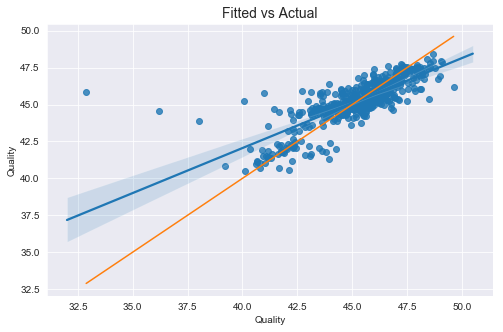


Dataset: no_tempinc_minmax.csv


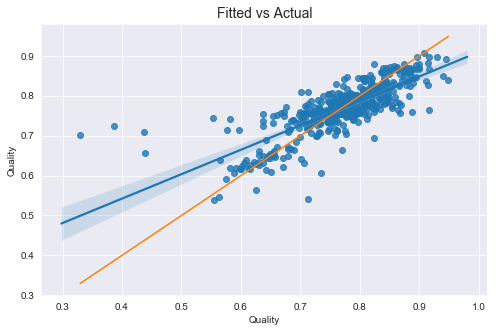


Dataset: no_tempinc_standard.csv


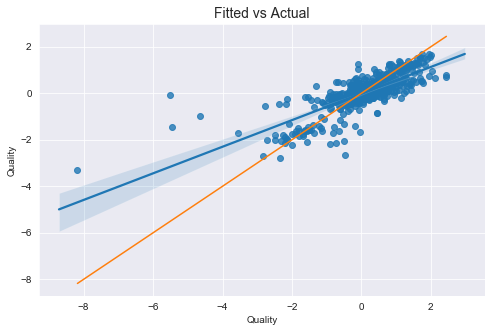


Dataset: tempinc.csv


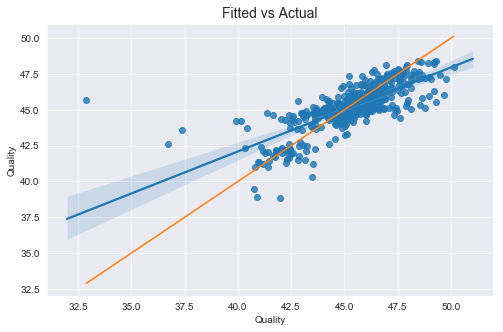


Dataset: tempinc_minmax.csv


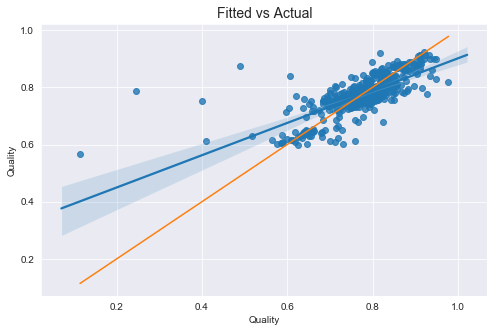


Dataset: tempinc_standard.csv


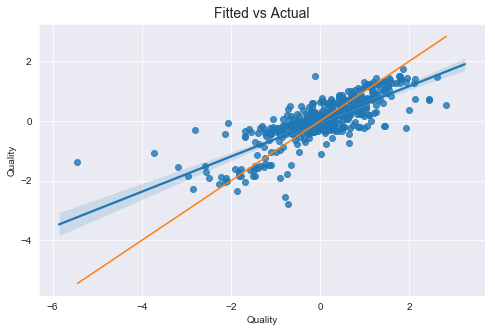

In [39]:
rf_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_train = train['Quality']
    train.drop(['Quality'], axis = 1, inplace = True)
    X_train = train
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val
    
    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                    min_samples_split = 9,min_samples_leaf = 4,
                    min_weight_fraction_leaf= 0.0)
    
    rf_fit = rf_reg.fit(X_train, y_train)
    rf_reg_preds = rf_fit.predict(X_val)
    
    mae = mean_absolute_error(y_val, rf_reg_preds)
    mse = mean_squared_error(y_val, rf_reg_preds)
    r_squared = r2_score(y_val, rf_reg_preds)
    
    rf_dict[str(file)] = {}
    rf_dict[str(file)]['mae'] = mae
    rf_dict[str(file)]['mse'] = mse
    rf_dict[str(file)]['r_squared'] = r_squared
    rf_dict[str(file)]['feat_imp'] = rf_reg.feature_importances_
    
        
    plt.figure(figsize=(8, 5))
    print('\nDataset:', str(file))
    sns.set_style("darkgrid")
    ax = sns.regplot(x=y_val, y=rf_reg_preds)
    ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
    plt.title("Fitted vs Actual",  fontsize='14')
    plt.show()

In [40]:
rf_df = pd.DataFrame.from_dict(rf_dict)

**With sampling**


Dataset: no_tempinc.csv Weight: 1


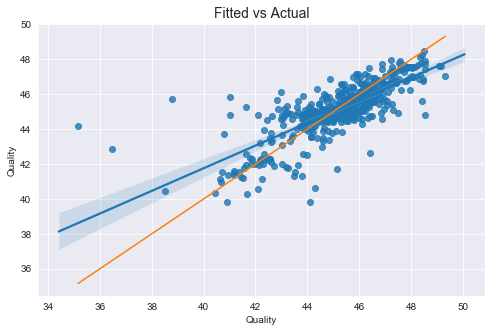


Dataset: no_tempinc.csv Weight: 3


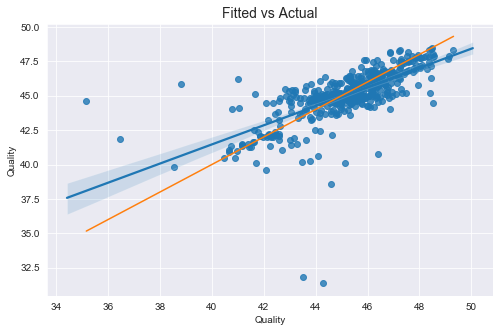


Dataset: no_tempinc.csv Weight: 5


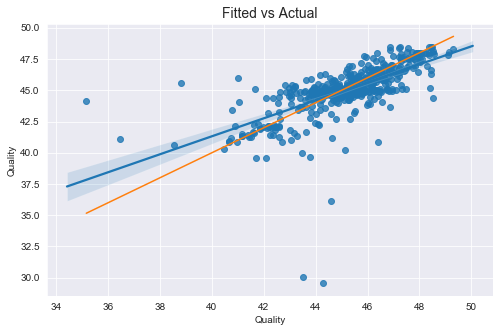


Dataset: no_tempinc_minmax.csv Weight: 1


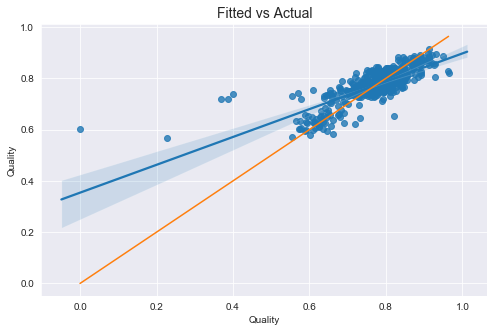


Dataset: no_tempinc_minmax.csv Weight: 3


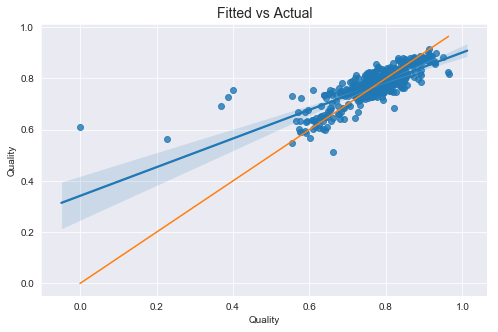


Dataset: no_tempinc_minmax.csv Weight: 5


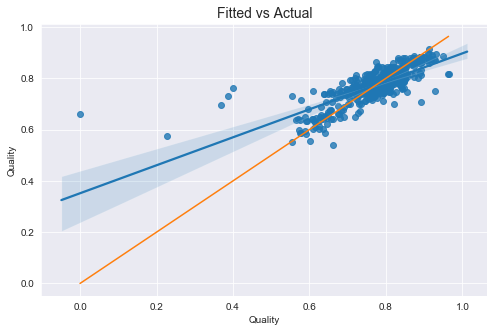


Dataset: no_tempinc_standard.csv Weight: 1


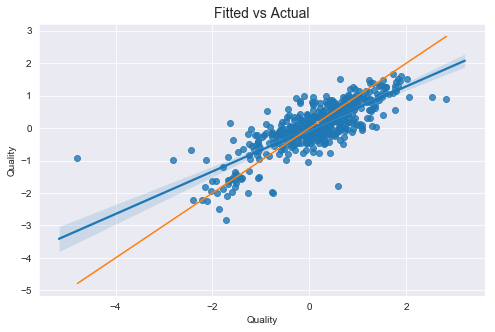


Dataset: no_tempinc_standard.csv Weight: 3


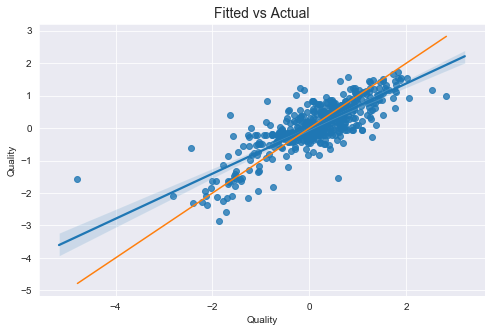


Dataset: no_tempinc_standard.csv Weight: 5


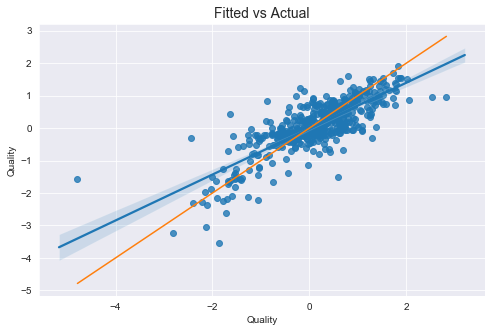


Dataset: tempinc.csv Weight: 1


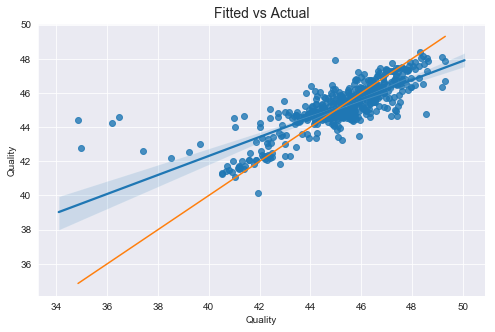


Dataset: tempinc.csv Weight: 3


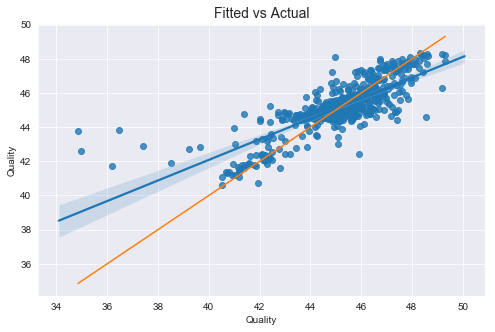


Dataset: tempinc.csv Weight: 5


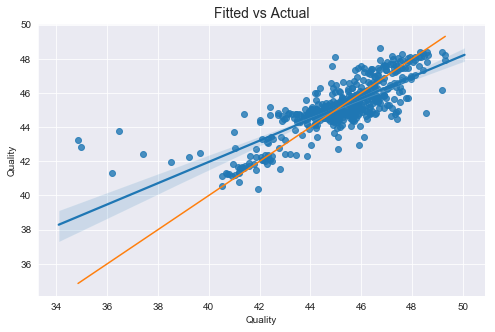


Dataset: tempinc_minmax.csv Weight: 1


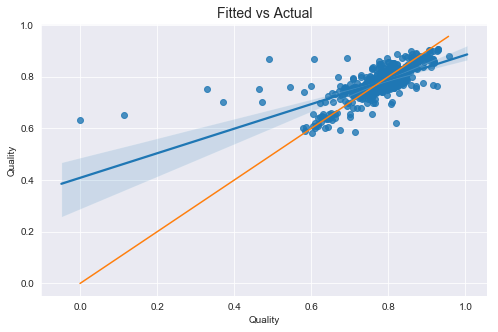


Dataset: tempinc_minmax.csv Weight: 3


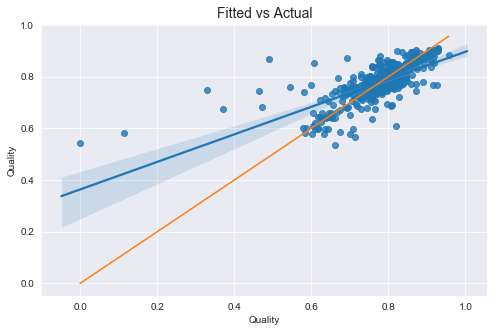


Dataset: tempinc_minmax.csv Weight: 5


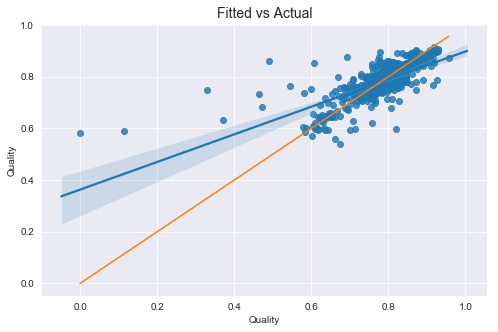


Dataset: tempinc_standard.csv Weight: 1


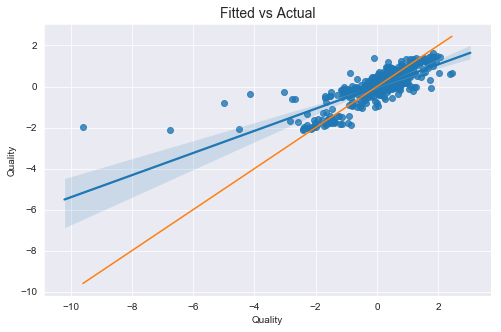


Dataset: tempinc_standard.csv Weight: 3


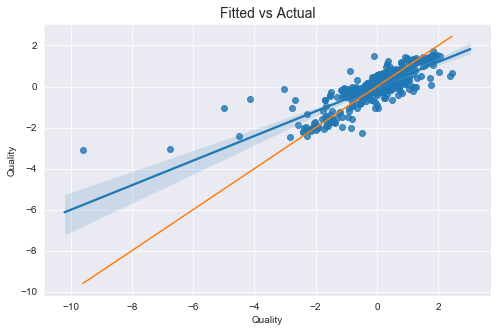


Dataset: tempinc_standard.csv Weight: 5


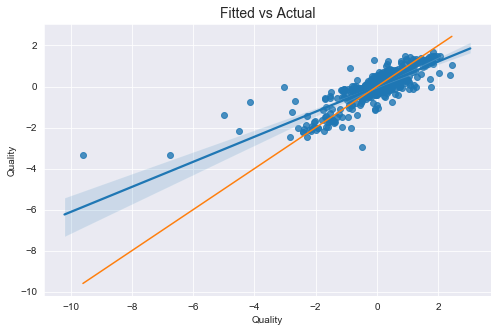

In [41]:
rf_s_dict = {}
os.chdir("../p_data")
for file in glob.glob('*.csv'):
#     print('\nData:',file)
    df = pd.read_csv(file)
    temp_train, val, test = np.split(df.sample(frac=1), 
                                [int(.6*len(df)), 
                                 int(.8*len(df))])
    
    y_val = val['Quality']
    val.drop(['Quality'], axis = 1, inplace = True)
    X_val = val

    y_test = test['Quality']
    test.drop(['Quality'], axis = 1, inplace = True)
    X_test = test
    
    for w in range(1,6,2):
#         print('Weight:',w)
        temp_df = oversample_extremes(temp_train, low_weight=w, high_weight = w)

        y_train = temp_df['Quality']
        temp_df.drop(['Quality'], axis = 1, inplace = True)
        X_train = temp_df

        rf_reg = RandomForestRegressor(n_jobs=5, n_estimators= 120, max_depth= 10,
                        min_samples_split = 9,min_samples_leaf = 4,
                        min_weight_fraction_leaf= 0.0)

        rf_fit = rf_reg.fit(X_train, y_train)
        rf_reg_preds = rf_fit.predict(X_val)
        
        mae = mean_absolute_error(y_val, rf_reg_preds)
        mse = mean_squared_error(y_val, rf_reg_preds)
        r_squared = r2_score(y_val, rf_reg_preds)
        
        rf_s_dict[str(file) + '_w' + str(w)] = {}
        rf_s_dict[str(file) + '_w' + str(w)]['mae'] = mae
        rf_s_dict[str(file) + '_w' + str(w)]['mse'] = mse
        rf_s_dict[str(file) + '_w' + str(w)]['r_squared'] = r_squared
        rf_s_dict[str(file) + '_w' + str(w)]['feat_imp'] = rf_reg.feature_importances_
        
        plt.figure(figsize=(8, 5))
        print('\nDataset:', str(file), "Weight:", w)
        sns.set_style("darkgrid")
        ax = sns.regplot(x=y_val, y=rf_reg_preds)
        ax = sns.lineplot(x=y_val, y=y_val, palette="00D415")
        plt.title("Fitted vs Actual",  fontsize='14')
        plt.show()

In [42]:
rf_s_df = pd.DataFrame.from_dict(rf_s_dict)

In [43]:
rf_summ = pd.concat([rf_df.T, rf_s_df.T])

In [44]:
rf_summ['Model'] = 'RandomForest'

In [45]:
model_summ = pd.concat([xgb_summ, rf_summ])

In [46]:
model_summ

,feat_imp,mae,mse,r_squared,Model
no_tempinc.csv,"[0.018961001, 0.012710622, 0.72244096, 0.01029...",0.667499,1.02595,0.661455,XGB
no_tempinc_minmax.csv,"[0.0032606525, 0.0, 0.004483474, 0.9209425, 0....",0.0299552,0.00379433,0.490006,XGB
no_tempinc_standard.csv,"[0.0028349657, 0.0, 0.004408698, 0.9122267, 0....",0.341918,0.282501,0.656675,XGB
tempinc.csv,"[0.00899829, 0.008351728, 0.77662575, 0.007496...",0.699491,1.20329,0.67468,XGB
tempinc_minmax.csv,"[0.002338941, 0.0, 0.0023245416, 0.90684587, 0...",0.029826,0.00229038,0.68316,XGB
tempinc_standard.csv,"[0.0037931504, 0.0, 0.004644645, 0.9039884, 0....",0.359193,0.294903,0.701696,XGB
no_tempinc.csv_w1,"[0.008001338, 0.010800438, 0.7399757, 0.011833...",0.656587,1.25501,0.577602,XGB
no_tempinc.csv_w3,"[0.002090232, 0.0020263763, 0.95450026, 0.0026...",0.639608,1.03622,0.65124,XGB
no_tempinc.csv_w5,"[0.002457941, 0.0024670034, 0.95070565, 0.0030...",0.662458,1.09966,0.629888,XGB
no_tempinc_minmax.csv_w1,"[0.0022805168, 0.0, 0.0017759677, 0.9446783, 0...",0.0271207,0.00311157,0.597274,XGB


In [48]:
# model_summ.sort_values(by = 'r_squared', ascending=False)